# Version 1.1
- import historic data from World Trading Data
- import latest price/meta data from World Trading Data
- assess age of funds
- assess median annual return
- use FB Prophet to assess expected trend and bounds of daily close
- suggest buy/sell based on relation between trend and current price, prioritising higher age and higher median return

In [1]:
from pytrade import stocks, datareader
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Initialise stocks, importing latest data

In [2]:
symbols = datareader.stocklist(platform='freetrade')

In [3]:
stock_obj = stocks.get(symbols, latest_flag=True, refresh_data=True)

## Compare the age of ETFs

In [4]:
age_lst = [(k, v.age) for k,v in stock_obj.items()]

In [5]:
age_lst.sort(key=lambda x: x[1], reverse=True)

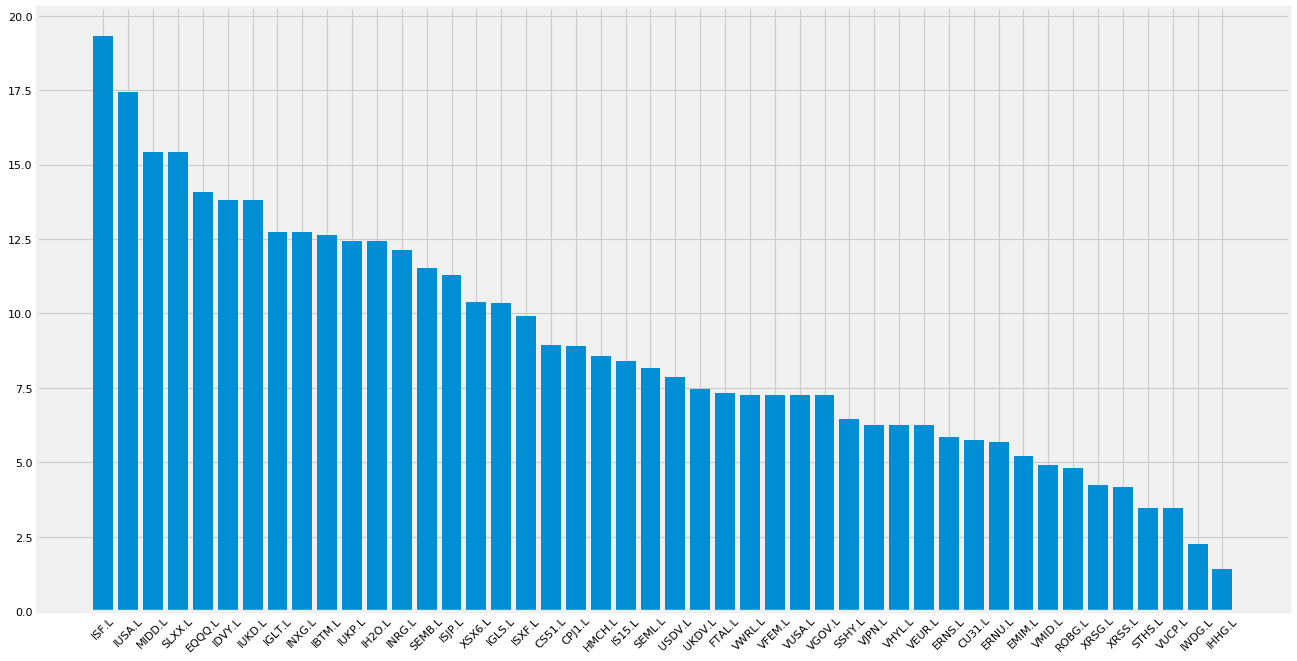

In [6]:
plt.figure(figsize=(18,10), dpi= 80)
plt.bar(range(len(age_lst)), [v[1] for v in age_lst], align='center')
plt.xticks(range(len(age_lst)), [v[0] for v in age_lst])
plt.xticks(rotation=45)
plt.show()

In [7]:
gt_10yrs = [i[0] for i in age_lst if i[1] >= 10]

##  Compare the median annual return of ETFs, over a 10 year period

In [8]:
return_lst = [(k, v.median_return(10)) for k,v in stock_obj.items() if k in gt_10yrs]

In [9]:
return_lst.sort(key=lambda x: x[1], reverse=True)

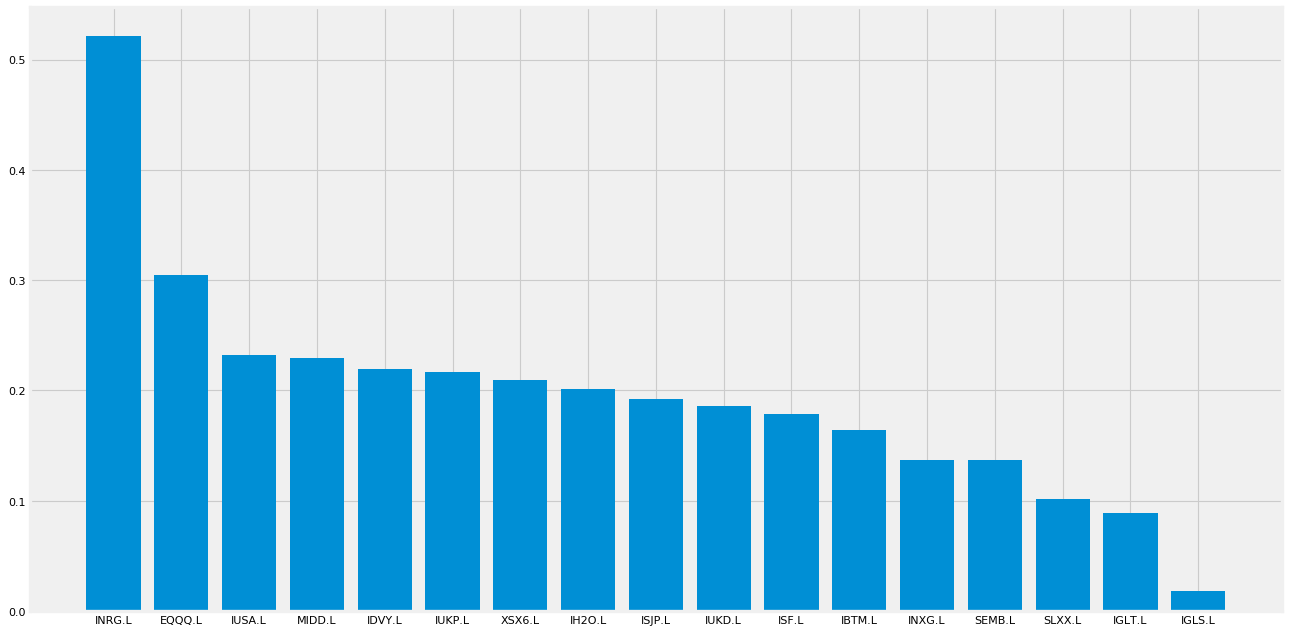

In [10]:
plt.figure(figsize=(18,10), dpi= 80)
plt.bar(range(len(return_lst)), [v[1] for v in return_lst], align='center')
plt.xticks(range(len(return_lst)), [v[0] for v in return_lst])
plt.show()

## Apply Prophet model to stocks

In [11]:
from fbprophet import Prophet
import pandas as pd

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [12]:
pd.plotting.register_matplotlib_converters()

In [13]:
def ffill_missing_dates(df):
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx, method='ffill')
    return df

In [14]:
def prophet_model(df):
    df = df.copy()
    df = df.rename(columns={'Close': 'y'})
    df['ds'] = df.index
    df.reset_index(inplace=True)
    df_model = Prophet()
    df_model.fit(df)
    df_forecast = df_model.make_future_dataframe(periods=13, freq='D')
    df_forecast = df_model.predict(df_forecast)
    df_forecast.set_index('ds', inplace=True)
    return df_forecast

In [15]:
def save_plot(df, df_forecast, symbol):
    plt.figure(figsize=(25, 10))
    plt.plot(df_forecast['yhat'], 'b-', label='yhat', linewidth=3)
    plt.plot(df.index, df['Close'], 'g-', label='price', linewidth=1)
    plt.fill_between(df_forecast.index, 
                     df_forecast.yhat_lower, 
                     df_forecast.yhat_upper,
                     color='gray', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(symbol)
    plt.savefig(f'{symbol}.png')


In [16]:
def buy_or_sell(price, date, df_forecast):
    
    yhat  = df_forecast.loc[ date , 'yhat' ]
    yhat_lower = df_forecast.loc[ date , 'yhat_lower' ]
    yhat_upper = df_forecast.loc[ date , 'yhat_upper' ]
    
    diff = ( price - yhat ) / yhat
        
    if price < yhat_lower:
        return ('buy', diff)
    
    elif price > yhat_upper:
        return ('sell', diff)
                
    else:
        return ('hold', diff)
    

In [17]:
%%capture
for k,v in stock_obj.items():
    df = v.historic_data
    df = ffill_missing_dates(df)
    df_forecast = prophet_model(df)
    save_plot(df, df_forecast, 'datastore/figures/' + k)
    v.buy_or_sell = buy_or_sell(v.latest_price, v.latest_date, df_forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [18]:
from collections import defaultdict

In [19]:
summary_dct = defaultdict(list)
for k,v in stock_obj.items():
    summary_dct['symbol'].append(k)
    summary_dct['age'].append(v.age)
    summary_dct['signal'].append(v.buy_or_sell[0])
    summary_dct['trend_diff'].append(v.buy_or_sell[1])
    summary_dct['median_return'].append(v.median_return(10))

In [20]:
df = pd.DataFrame.from_records(summary_dct)

In [21]:
df.set_index('symbol', inplace=True)

In [22]:
df_buy = df[ (df['signal'] == 'buy') & (df['age'] > 5) ]
# add corrected median return...

In [23]:
df_buy.sort_values(by=['trend_diff'], ascending=True)

,age,median_return,signal,trend_diff
symbol,,,,
ISF.L,19.320548,0.178325,buy,-0.064170
IUKD.L,13.800000,0.186346,buy,-0.059044
IUKP.L,12.435616,0.216885,buy,-0.048025
EMIM.L,5.202740,0.237542,buy,-0.040481


In [24]:
df_sell = df[ (df['signal'] == 'sell') ]

In [25]:
df_sell.sort_values(by=['trend_diff'], ascending=False)

,age,median_return,signal,trend_diff
symbol,,,,
IBTM.L,12.646575,0.163845,sell,0.137562
SEMB.L,11.517808,0.136982,sell,0.102257
INXG.L,12.717808,0.137424,sell,0.095578
IH2O.L,12.435616,0.201425,sell,0.080569
SEML.L,8.178082,0.148313,sell,0.065495
CS51.L,8.942466,0.224536,sell,0.063567
IGLT.L,12.726027,0.088846,sell,0.049249
SLXX.L,15.410959,0.101761,sell,0.046057
XSX6.L,10.394521,0.209374,sell,0.041192
